# Negative Fake Companion Technique 
## Using GPU

In [1]:
import matplotlib.pyplot as plt 
import tensorflow as tf 
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import numpy as np
import os

from vip_hci.fits import open_fits

from vip.plottools import create_circular_mask 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import gpu.fake_comp as tfnegfc


os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%load_ext autoreload
%autoreload 2

2023-05-17 15:26:40.010885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 15:26:40.825001: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-17 15:26:40.825063: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-17 15:26:40.825068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

### Loading data

In [3]:
root = './data/HCI/'

cube_route = os.path.join(root, 'center_im.fits')
cube       = open_fits(cube_route, header=False) 

psf_route = os.path.join(root, 'median_unsat.fits')
psf       = open_fits(psf_route, header=False)

ra_route = os.path.join(root, 'rotnth.fits')
rot_ang  = open_fits(ra_route, header=False)
rot_ang  = -rot_ang

lambda_ch = 0 # channel to use
psf_pos   = 0 # psf position

Fits HDU-0 data successfully loaded. Data shape: (2, 90, 201, 201)
Fits HDU-0 data successfully loaded. Data shape: (2, 2, 64, 64)
Fits HDU-0 data successfully loaded. Data shape: (90,)


### Normalizing PSF: Creating a template to mimic companions 

The first step consists in creating the fake companion template we will use later to mimic the real one.

We need first to find the real center and standard deviation of the PSF by fitting a gaussian model on pixels, 

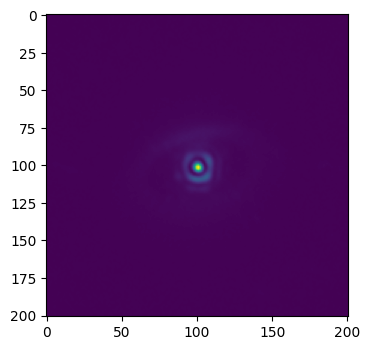

In [4]:
plt.figure(dpi=100)
plt.imshow(cube[0, 0])

In [5]:
results = tfnegfc.adjust_gaussian(psf[lambda_ch, psf_pos])

2023-05-17 15:26:50.383889: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-05-17 15:26:50.386353: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-05-17 15:26:50.386402: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas


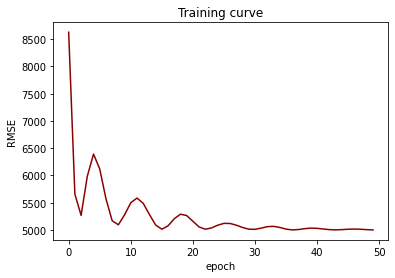

In [6]:
plt.plot(results['history'], color='darkred')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('Training curve')
plt.show()

Assuming an sphere (i.e., same FWHM along the PSFs) we center all the availables PSFs. This is not used yet, but worth for future work:

In [7]:
fwhm_sphere  = tf.reduce_mean(results['fwhm'])
centered_psf = tfnegfc.center_cube(psf[lambda_ch], fwhm_sphere)
centered_psf.shape

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


TensorShape([2, 64, 64])

Once all the PSFs were aligned we can normalize it to have a 1-FWHM in an aperture equal to FWHM//2

In [8]:
normalized_psf = tfnegfc.normalize_psf(centered_psf, fwhm=fwhm_sphere)

### PCA: Extracting most variable pixels along the time axis from the cube of frames

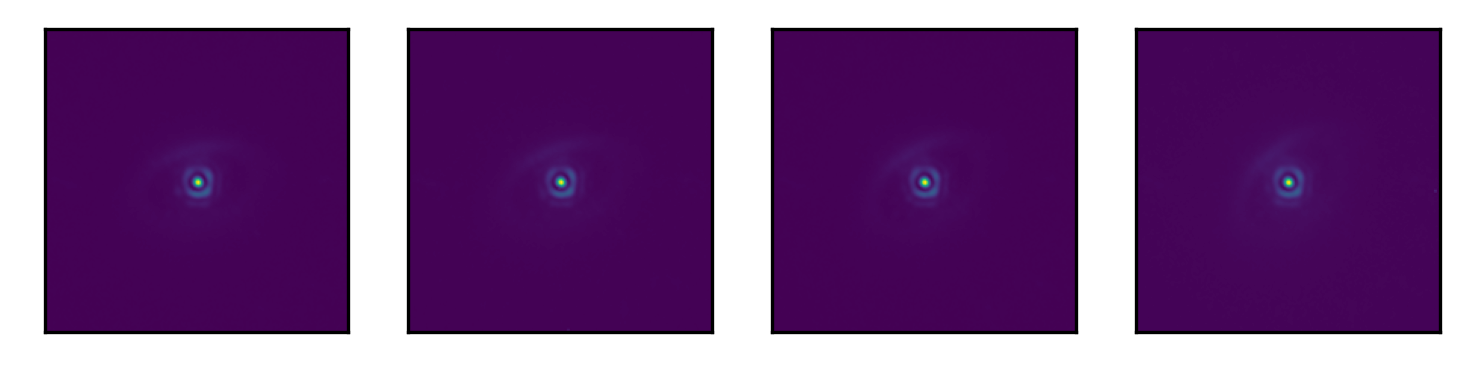

In [9]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, dpi=300)
axes = axes.flatten()
for i, nf in enumerate(range(0, len(cube[0]), 10)):
    try:
        axes[i].imshow(cube[0, nf])
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    except:
        break

In [10]:
cube[0].shape

(90, 201, 201)

In [11]:
%%time
adi_image, res_cube = tfnegfc.apply_adi(cube[0], 
                                        rot_ang, 
                                        out_size=cube[0].shape, 
                                        ncomp=1, 
                                        derotate='tf', return_cube=True)

CPU times: user 916 ms, sys: 348 ms, total: 1.26 s
Wall time: 1.28 s


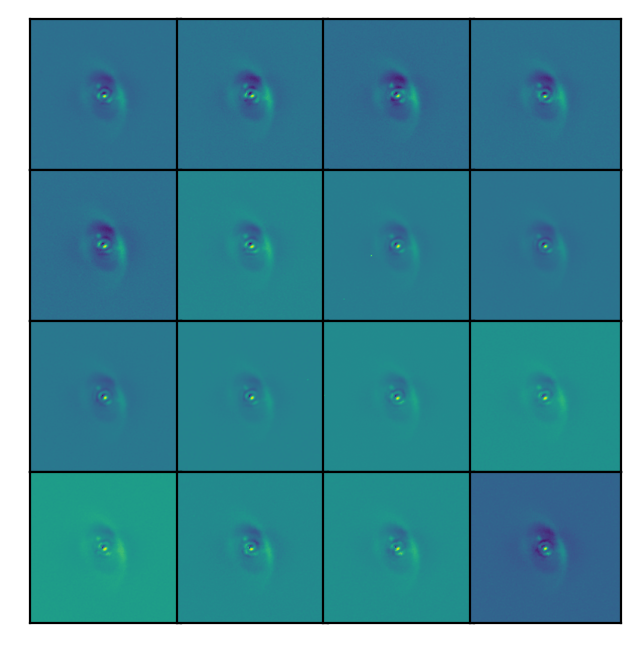

In [12]:
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, dpi=200,
                        gridspec_kw={'hspace': 0., 'wspace': -0.7},)
axes = axes.flatten()

for i in range(16):
    axes[i].imshow(res_cube[i])
    axes[i].set_xticks([])
    axes[i].set_yticks([])

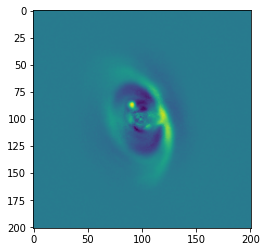

In [13]:
plt.imshow(adi_image)

In [14]:
%%time
table = tfnegfc.get_coords(adi_image.numpy(), fwhm=fwhm_sphere, bkg_sigma=5, cut_size=10)

CPU times: user 4.14 s, sys: 47.6 ms, total: 4.19 s
Wall time: 4.13 s


In [15]:
table

,x,y,flux,fwhm_mean,snr
0,91.430794,86.833885,3.315128,4.139935,2.715651
1,106.392303,106.029022,1.466272,4.254222,1.737472
2,89.601738,99.557083,1.275042,4.414632,1.308844


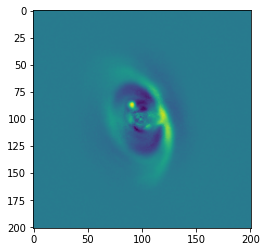

In [16]:
plt.figure()
plt.imshow(adi_image)
plt.show()

### Fiting parameters

In [29]:
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.optimizers.experimental import SGD
from gpu.negfc_models import get_model
from gpu.losses import custom_loss
from gpu.data import get_dataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
def wrapper(fn, fwhm, std=True):
    def inner(*args):
        out = fn(*args, fwhm=fwhm, std=std)
        return out
    return inner

In [56]:
nfwhm = 1
custom_loss_w = wrapper(custom_loss, fwhm=table.iloc[0]['fwhm_mean']*nfwhm, std=False)

dataset, recovery = get_dataset(cube, normalized_psf, rot_ang, normalize=0)

model = get_model(x_init=table.iloc[0]['x'], 
                  y_init=table.iloc[0]['y'], 
                  cube=cube)    
# model.summary()

(41.43079376220703, 141.43079376220703)

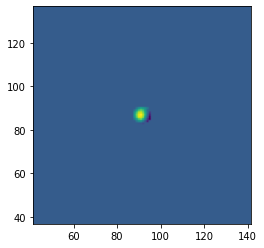

In [57]:
x_ = table.iloc[0]['x']
y_ = table.iloc[0]['y']
fwhm_ = table.iloc[0]['fwhm_mean']

obj_reg = tfnegfc.get_objective_region(adi_image, x_, y_, rot_ang, fwhm_*nfwhm)
plt.figure()
plt.imshow(obj_reg[0])
plt.ylim(y_-50, y_+50)
plt.xlim(x_-50, x_+50)

In [58]:
%%time
es = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=40,
)
model.compile(loss_fn=custom_loss_w, optimizer=Adam(1))

hist = model.fit(dataset, epochs=10000, verbose=1, callbacks=[es])

Epoch 1/10000
1/1 [==============================] - 3s 3s/step - loss: 2940.8340
Epoch 2/10000
1/1 [==============================] - 0s 205ms/step - loss: 2877.9888
Epoch 3/10000
1/1 [==============================] - 0s 210ms/step - loss: 2816.4304
Epoch 4/10000
1/1 [==============================] - 0s 210ms/step - loss: 2754.9307
Epoch 5/10000
1/1 [==============================] - 0s 210ms/step - loss: 2692.7134
Epoch 6/10000
1/1 [==============================] - 0s 214ms/step - loss: 2630.9390
Epoch 7/10000
1/1 [==============================] - 0s 200ms/step - loss: 2570.1772
Epoch 8/10000
1/1 [==============================] - 0s 210ms/step - loss: 2511.6182
Epoch 9/10000
1/1 [==============================] - 0s 211ms/step - loss: 2454.5693
Epoch 10/10000
1/1 [==============================] - 0s 209ms/step - loss: 2399.8083
Epoch 11/10000
1/1 [==============================] - 0s 203ms/step - loss: 2346.9353
Epoch 12/10000
1/1 [==============================] - 0s 210ms/ste

1/1 [==============================] - 0s 213ms/step - loss: 156.3610
Epoch 98/10000
1/1 [==============================] - 0s 204ms/step - loss: 150.3220
Epoch 99/10000
1/1 [==============================] - 0s 212ms/step - loss: 144.3982
Epoch 100/10000
1/1 [==============================] - 0s 207ms/step - loss: 138.7406
Epoch 101/10000
1/1 [==============================] - 0s 205ms/step - loss: 133.3311
Epoch 102/10000
1/1 [==============================] - 0s 206ms/step - loss: 128.0685
Epoch 103/10000
1/1 [==============================] - 0s 216ms/step - loss: 123.0022
Epoch 104/10000
1/1 [==============================] - 0s 201ms/step - loss: 118.0581
Epoch 105/10000
1/1 [==============================] - 0s 211ms/step - loss: 113.2728
Epoch 106/10000
1/1 [==============================] - 0s 215ms/step - loss: 108.6500
Epoch 107/10000
1/1 [==============================] - 0s 209ms/step - loss: 104.2954
Epoch 108/10000
1/1 [==============================] - 0s 196ms/step - l

1/1 [==============================] - 0s 207ms/step - loss: 1.8244
Epoch 194/10000
1/1 [==============================] - 0s 202ms/step - loss: 1.7289
Epoch 195/10000
1/1 [==============================] - 0s 208ms/step - loss: 1.6380
Epoch 196/10000
1/1 [==============================] - 0s 202ms/step - loss: 1.5515
Epoch 197/10000
1/1 [==============================] - 0s 218ms/step - loss: 1.4697
Epoch 198/10000
1/1 [==============================] - 0s 201ms/step - loss: 1.3915
Epoch 199/10000
1/1 [==============================] - 0s 204ms/step - loss: 1.3175
Epoch 200/10000
1/1 [==============================] - 0s 212ms/step - loss: 1.2471
Epoch 201/10000
1/1 [==============================] - 0s 215ms/step - loss: 1.1801
Epoch 202/10000
1/1 [==============================] - 0s 217ms/step - loss: 1.1158
Epoch 203/10000
1/1 [==============================] - 0s 205ms/step - loss: 1.0550
Epoch 204/10000
1/1 [==============================] - 0s 207ms/step - loss: 0.9971
Epoch 20

1/1 [==============================] - 0s 200ms/step - loss: 0.0027
Epoch 291/10000
1/1 [==============================] - 0s 213ms/step - loss: 0.0024
Epoch 292/10000
1/1 [==============================] - 0s 211ms/step - loss: 0.0022
Epoch 293/10000
1/1 [==============================] - 0s 202ms/step - loss: 0.0021
Epoch 294/10000
1/1 [==============================] - 0s 202ms/step - loss: 0.0019
Epoch 295/10000
1/1 [==============================] - 0s 202ms/step - loss: 0.0018
Epoch 296/10000
1/1 [==============================] - 0s 204ms/step - loss: 0.0016
Epoch 297/10000
1/1 [==============================] - 0s 200ms/step - loss: 0.0015
Epoch 298/10000
1/1 [==============================] - 0s 203ms/step - loss: 0.0014
Epoch 299/10000
1/1 [==============================] - 0s 214ms/step - loss: 0.0013
Epoch 300/10000
1/1 [==============================] - 0s 211ms/step - loss: 0.0012
Epoch 301/10000
1/1 [==============================] - 0s 205ms/step - loss: 0.0011
Epoch 30

1/1 [==============================] - 0s 214ms/step - loss: 1.2233e-07
Epoch 384/10000
1/1 [==============================] - 0s 215ms/step - loss: 1.0967e-07
Epoch 385/10000
1/1 [==============================] - 0s 199ms/step - loss: 9.6213e-08
Epoch 386/10000
1/1 [==============================] - 0s 209ms/step - loss: 8.3087e-08
Epoch 387/10000
1/1 [==============================] - 0s 218ms/step - loss: 7.2712e-08
Epoch 388/10000
1/1 [==============================] - 0s 217ms/step - loss: 6.3268e-08
Epoch 389/10000
1/1 [==============================] - 0s 204ms/step - loss: 5.4592e-08
Epoch 390/10000
1/1 [==============================] - 0s 216ms/step - loss: 4.7279e-08
Epoch 391/10000
1/1 [==============================] - 0s 217ms/step - loss: 3.9728e-08
Epoch 392/10000
1/1 [==============================] - 0s 201ms/step - loss: 3.1465e-08
Epoch 393/10000
1/1 [==============================] - 0s 201ms/step - loss: 2.7378e-08
Epoch 394/10000
1/1 [===========================

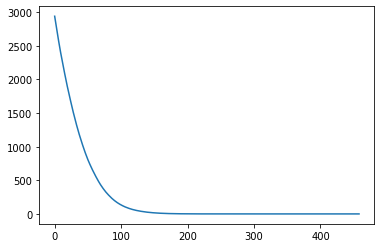

In [60]:
plt.plot(hist.history['loss'])

In [61]:
x_firstguess = model.trainable_variables[0]
y_firstguess = model.trainable_variables[1]
flux_firstguess = model.trainable_variables[2]#*(recovery[0]-recovery[0]) + recovery[0]
flux_firstguess = flux_firstguess[0]
print('x: {}'.format(x_firstguess[0]))
print('y: {}'.format(y_firstguess[0]))
print('flux: {}'.format(flux_firstguess))

x: 91.43079376220703
y: 86.8338851928711
flux: 102.07369232177734


In [62]:
patch = tfnegfc.create_patch(cube[0, 0], normalized_psf[0])

fake_zeros = tfnegfc.inject_fake(x=x_firstguess, y=y_firstguess, flux = -flux_firstguess, 
                                cube=tf.zeros_like(cube[0]), 
                                patch=patch, 
                                rot_angles=rot_ang)
adi_image_fake_zeros = tfnegfc.apply_adi(fake_zeros, 
                                   rot_ang, 
                                   out_size=(cube[0].shape),
                                   ncomp=1, 
                                   derotate='tf')

Text(0.5, 1.0, 'Residuals')

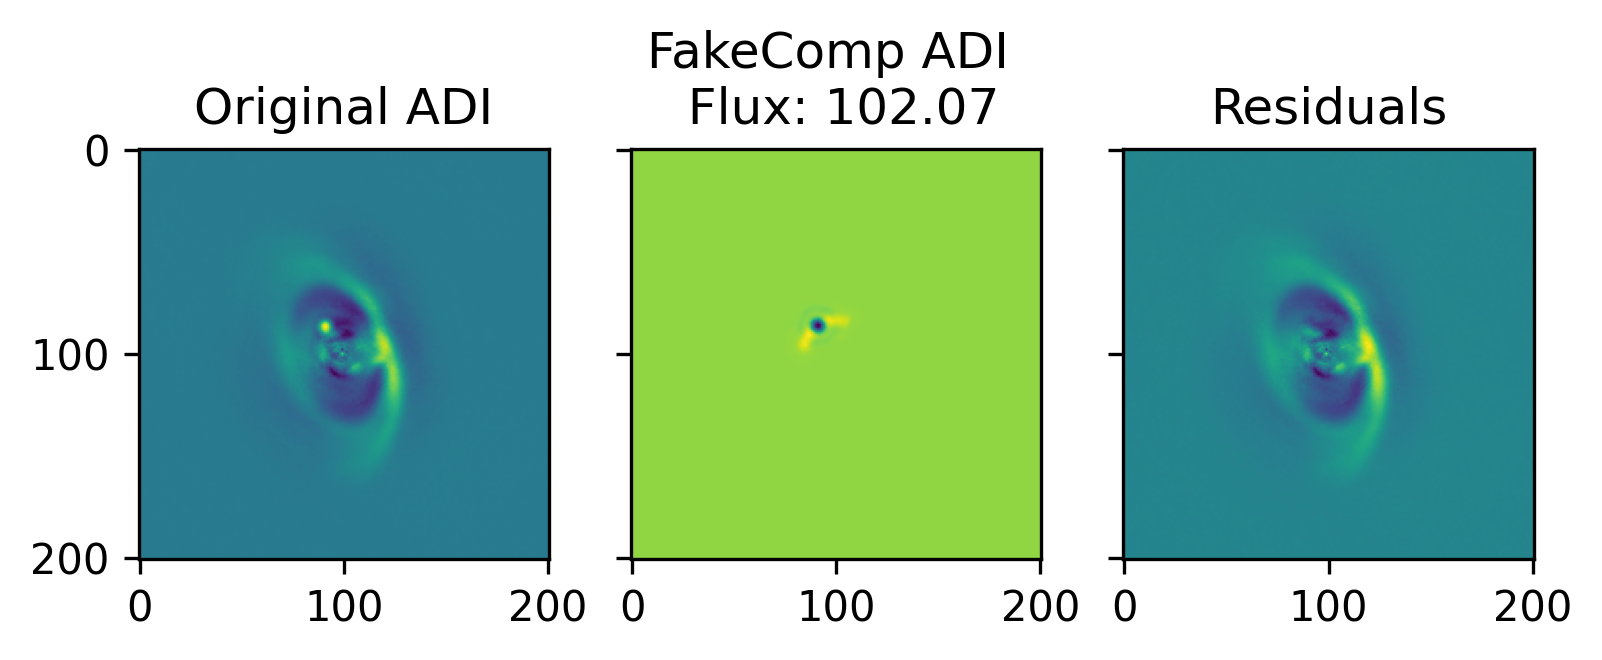

In [63]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, dpi=300)
axes[0].imshow(adi_image)
axes[0].set_title('Original ADI')
axes[1].imshow(adi_image_fake_zeros)
axes[1].set_title('FakeComp ADI \n Flux: {:.2f}'.format(flux_firstguess))
axes[2].imshow(adi_image+adi_image_fake_zeros)
axes[2].set_title('Residuals')

# axes[2].set_xlim(x_firstguess-100, x_firstguess+100)
# axes[2].set_ylim(y_firstguess-100, y_firstguess+100)

### MCMC

In [48]:
from gpu.mcmc import run_chain, run_chain_only_flux

In [49]:
# %%time
# init_state = [x_firstguess.numpy()[0], y_firstguess.numpy()[0], flux_firstguess]
# results = run_chain(init_state, fwhm_*2, cube[0], normalized_psf[0], 
#                     rot_ang, num_results=10000)
# titles = ['x', 'y', 'flux']

In [50]:
%%time
init_state = [flux_firstguess]

results = run_chain_only_flux(init_state, 
                              x_firstguess, 
                              y_firstguess, 
                              table.iloc[0]['fwhm_mean']*3, 
                              cube[0], 
                              normalized_psf[0], 
                              rot_ang, 
                              num_results=5000)
titles = ['flux']

/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
2023-05-16 16:33:10.564081: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: mcmc_sample_chain/transformed_kernel_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/cond_1/branch_executed/_41


CPU times: user 1min 48s, sys: 9.53 s, total: 1min 58s
Wall time: 47.6 s


In [51]:
start = 0
samples = [r[start:] for r in results.all_states]
opt_values = [np.mean(samples_chain) for samples_chain in samples]

for initial_val, final_val in zip(init_state, opt_values):
    print(initial_val,' - ', final_val)

tf.Tensor(102.07369, shape=(), dtype=float32)  -  97.322716


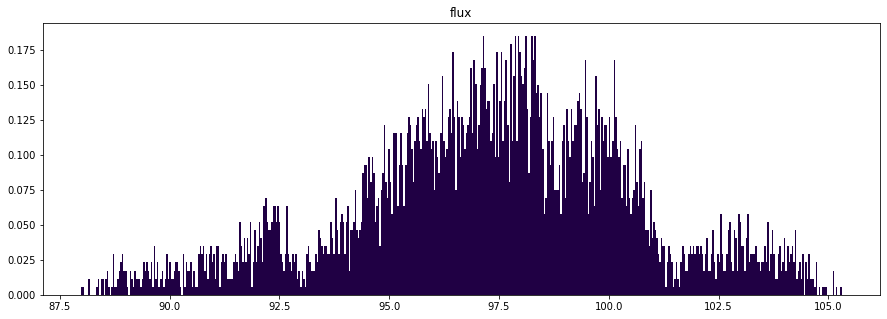

In [53]:
fig, axes = plt.subplots(1, len(init_state), figsize=(15,5))
if len(init_state)>1: 
    axes = axes.flatten()
else:
    axes = [axes]
    
for i, r in enumerate(samples):
    axes[i].hist(np.ravel(r), bins=500, color='#200044', density=True)
    axes[i].set_title(titles[i])

## Visualizing Results

In [247]:
try:
    x_star = opt_values[0]
    y_star = opt_values[1]
    flux_star = opt_values[2]
except:
    x_star = x_firstguess.numpy()[0]
    y_star = y_firstguess.numpy()[0]
    flux_star = opt_values[0]

In [248]:
x_star, y_star, flux_star

(91.43079, 86.833885, 87.77761)

In [249]:
patch = tfnegfc.create_patch(cube[0, 0], normalized_psf[0])

fake_cube = tfnegfc.inject_fake(x = x_star, 
                                y = y_star, 
                                flux  = -flux_star, 
                                cube  = cube[0], 
                                patch = patch, 
                                rot_angles = rot_ang)

fake_cube_adi = tfnegfc.apply_adi(fake_cube, 
                                  rot_ang, 
                                  out_size=(cube[0].shape),
                                  ncomp=1, 
                                  derotate='tf')

In [ ]:
plt.figure(figsize=(5,5),dpi=200)
plt.imshow(fake_cube_adi)
plt.title('(x, y) = ({:.2f}, {:.2f}) - flux {:.2f}'.format(x_star, y_star, flux_star))
plt.xticks([])
plt.yticks([])
plt.show()